In [3]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import strawberryfields as sf
from strawberryfields import ops

%config InlineBackend.figure_format='retina'

At first we want to see how we can implement the $\hat{L}_z^2$ operation in the pennylane language. Just like in the example of the paper of Cindy Regal we will start off by modeling the number of $|\uparrow\rangle$ states and $|\downarrow\rangle$ states with Fock states. This is called "dual rail encoding". <font color=purple> This is also exactly what we do physically. It is also called Schwinger representation of a spin. All different names for the same thing ...</font>

We can write the $\hat{L}_z^2$ operator in exponential from with Kerr $K_i(\kappa)=e^{i\kappa n_i^2}$ and Cross-Kerr gates $KC_{i, j}(\kappa)=e^{i\kappa n_in_j}$. $\hat{L}_z^2 = (n_1 - n_2)^2 = n_1^2 - 2n_1n_2 + n_2^2$.

In [4]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_test(kappa, var=False):
    qml.FockState(5, wires=0)
    qml.FockState(0, wires=1)
    qml.Kerr(kappa, wires=0)
    qml.Kerr(kappa, wires=1)
    qml.CrossKerr(-kappa*2, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    


In [5]:
Kerr_test(1)
print(Kerr_test.draw())

 0: ──|5⟩──Kerr(1)──╭CrossKerr(-2)──┤ ⟨n⟩ 
 1: ──|0⟩──Kerr(1)──╰CrossKerr(-2)──┤ ⟨n⟩ 



In [6]:
print(Kerr_test(1))


print("variance =", Kerr_test(1, var=True))

[5. 0.]
variance = [0. 0.]


In [7]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_beamsplitter(theta, kappa, var=False):
    qml.FockState(5, wires=0)
    qml.FockState(0, wires=1)
    
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    qml.Kerr(kappa, wires=0)
    qml.Kerr(kappa, wires=1)
    qml.CrossKerr(-kappa*2, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    



In [8]:
thetas = np.linspace(0, np.pi/2, 10)
print(list(Kerr_beamsplitter(1, theta) for theta in thetas))

[array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709]), array([1.45963291, 3.54036709])]


Direct implementation in the stawberryfields plugin to extract samples

In [9]:
def circuit(theta, kappa, bs=False):
    prog = sf.Program(2)
    with prog.context as q:
        ops.Fock(5) | q[0]
        ops.Fock(0) | q[1]
        if bs:            
            ops.BSgate(theta, 0) | (q[0], q[1])
            
        ops.Kgate(kappa)   | q[0]
        ops.CKgate(kappa)  | (q[0], q[1])
        ops.Kgate(-2*kappa)| q[1]

        ops.MeasureFock()| q
    eng = sf.Engine("fock", backend_options={"cutoff_dim" :  10})
    result = eng.run(prog)
    return result



In [10]:
thetas = np.linspace(0 ,np.pi/2, 15)
result = np.array([circuit(i, 1).samples for i in thetas])
result_bs = np.array([circuit(i, 1, bs=True).samples for i in thetas])

In [11]:

print(result)
print("")
print(result_bs)

[[[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]

 [[5 0]]]

[[[5 0]]

 [[5 0]]

 [[5 0]]

 [[4 1]]

 [[4 1]]

 [[4 1]]

 [[4 1]]

 [[2 3]]

 [[2 3]]

 [[0 5]]

 [[1 4]]

 [[1 4]]

 [[0 5]]

 [[1 4]]

 [[0 5]]]


In [12]:
thetas = np.linspace(0 ,np.pi/2, 15)
result = [circuit(i, 0).samples for i in thetas]

# Ramsey

Let us implement a simple example, where the $L_z^2$ is sandwiched in between two symmetric beamsplitters:

- A first beamsplitter around $X$ moves the spin onto the equator centered around $Y$.
- The non-linearity squeezes the state.
- The second beam splitter around $Y$ transforms fluctuations in the $XY$ component into fluctuations on $Z$

In [117]:
dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=11)

@qml.qnode(dev)
def Kerr_Ramsey(kappa, theta2=np.pi/4, var=False):
    '''
    Sandwich the Lz^2 in between two Beamsplitters. What we change is the time that the non-linearity is applied.
    '''
    qml.FockState(5, wires=0)
    qml.FockState(0, wires=1)
    
    qml.Beamsplitter(np.pi/4, 0, wires=[0, 1])
    qml.Kerr(kappa, wires=0)
    qml.Kerr(kappa, wires=1)
    qml.CrossKerr(-kappa*2, wires=[0, 1])
    qml.Beamsplitter(theta2, np.pi/2, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    


In [118]:
Kerr_Ramsey(1)
print(Kerr_Ramsey.draw())

 0: ──|5⟩──╭BS(0.785, 0)──Kerr(1)──╭CrossKerr(-2)──╭BS(0.785, 1.571)──┤ ⟨n⟩ 
 1: ──|0⟩──╰BS(0.785, 0)──Kerr(1)──╰CrossKerr(-2)──╰BS(0.785, 1.571)──┤ ⟨n⟩ 



In [119]:
Nkappa = 51;
kappas = np.linspace(0, np.pi/2, Nkappa);
meansUp = np.zeros(Nkappa);
meansDown = np.zeros(Nkappa);

varsUp = np.zeros(Nkappa);
varsDown = np.zeros(Nkappa);

for ii in np.arange(Nkappa):
    meansUp [ii], meansDown[ii] = Kerr_Ramsey(kappas[ii])
    varsUp [ii], varsDown[ii] = Kerr_Ramsey(kappas[ii], var = True)
    
Lz_mean = meansUp - meansDown
Lz_var = varsUp + varsDown

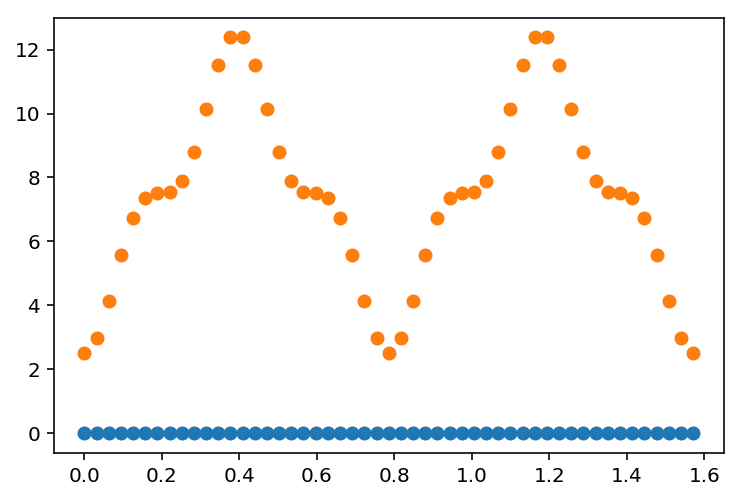

In [120]:
f, ax = plt.subplots()
ax.plot(kappas, Lz_mean, 'o', label='mean')
ax.plot(kappas, Lz_var, 'o', label='var')

so we can now actually fix the duration of the non-linearity to the point, where we observed the biggest fluctuations and rotate it through.

In [121]:
kappa = np.pi/16;

Ntheta2 = 51;
thetas = np.linspace(0, np.pi/2, Ntheta2);
meansUp = np.zeros(Ntheta2);
meansDown = np.zeros(Ntheta2);

varsUp = np.zeros(Ntheta2);
varsDown = np.zeros(Ntheta2);

for ii in np.arange(Ntheta2):
    meansUp [ii], meansDown[ii] = Kerr_Ramsey(kappa, theta2=thetas[ii])
    varsUp [ii], varsDown[ii] = Kerr_Ramsey(kappa, theta2=thetas[ii], var = True)
    
Lz_mean = meansUp - meansDown
Lz_var = varsUp + varsDown

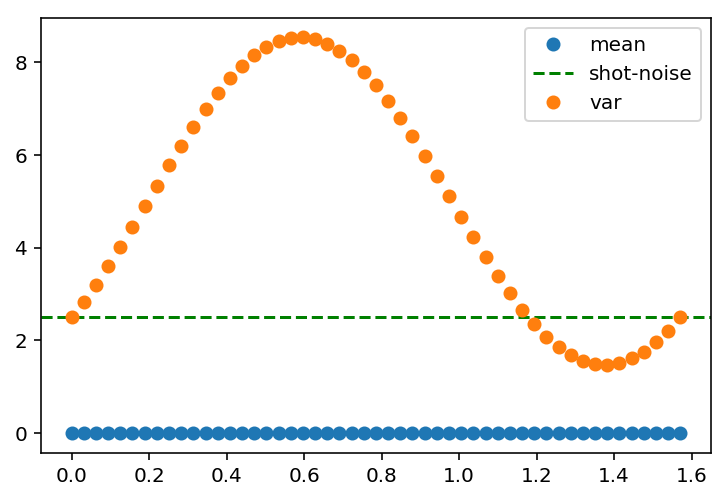

In [122]:
f, ax = plt.subplots()
ax.plot(thetas, Lz_mean, 'o', label='mean')
plt.axhline(y=2.5, linestyle="--", color="green", label="shot-noise")
ax.plot(thetas, Lz_var, 'o', label='var')
ax.legend()